# Marketing and business strategy

**Objective**  
Analyze the market and optimize them strategies to attract more clients.

**Objective Sprint 2**  
What accommodation characteristics (amenities, capacity, and area rating) are most related to prices in each city?

**Description and characteristics of dataset**  
Pre-processed and cleaned dataframe with tourist accommodations listings.

### Libraries

In [43]:
# import libraries 
import os
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from dotenv import load_dotenv, find_dotenv
from download_data import get_latest_table

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

## Load environment variables

In [44]:
# load environment variables
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")

# environment variables because we need connect to mysql
CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('HOST'),
    'database': 'Equip_F',
    'raise_on_warnings': True
}

### Connection to MySQL

In [45]:
import mysql.connector
from mysql.connector import Error

try:
    # Establish connection to MySQL
    connection = mysql.connector.connect(**CONFIG)
    
    if connection.is_connected():
        db_info = connection.get_server_info()
        print(f"Conexión exitosa a MySQL Server versión {db_info}")
        cursor = connection.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"Conectado a la base de datos: {record[0]}")

except Error as e:
    print(f"Error al conectar a MySQL: {e}")

Conexión exitosa a MySQL Server versión 8.0.41-0ubuntu0.24.04.1
Conectado a la base de datos: Equip_F


## Overview data

In [46]:
#df_new = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation""", connection)
#df_new.shape


## Business Question 2
### What accommodation characteristics (amenities, capacity, and area rating) are most related to prices in each city?

In [47]:
df = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation""", connection)
df.shape
df.info()

C:\Users\admin\AppData\Local\Temp\ipykernel_14960\472372921.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""SELECT * FROM ST1_Tourist_Accommodation""", connection)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7643 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7652 non-null   float64       
 9   bedrooms                     7654 non-null   float64       
 10  beds                         7685 non-null   float64       
 11  amenities_list               7677 non-null 

## Cleaning ameneties_list

In [48]:
import pandas as pd
import re

def clean_amenities(amenities_str):
    if pd.isna(amenities_str) or amenities_str == '':
        return ''

    # Remove brackets and split by comma
    amenities_list = re.sub(r'[\[\]\']', '', amenities_str).split(',')

    # Remove extra whitespace and empty strings
    cleaned_list = [amenity.strip() for amenity in amenities_list if amenity.strip()]

    # Join back into a comma separated string
    return ','.join(cleaned_list)

df['amenities_list'] = df['amenities_list'].apply(clean_amenities)

## Create table N with amenities_list

In [49]:
#create table N with amenities_list
import pandas as pd

amenities_expanded = []
for index, row in df.iterrows():
    apartment_id = row['apartment_id']
    amenities = row['amenities_list']
    if amenities:
        amenities_list = amenities.split(',')
        for i, amenity in enumerate(amenities_list):
            amenities_expanded.append([apartment_id, i + 1, amenity.strip()])

amenities_df = pd.DataFrame(amenities_expanded, columns=['apartment_id', 'id_correlativo', 'prestacion'])
amenities_df

,apartment_id,id_correlativo,prestacion
0,11964,1,TV
1,11964,2,Internet
2,11964,3,Wifi
3,11964,4,Air conditioning
4,11964,5,Elevator
...,...,...,...
167569,32423292,3,Pets allowed
167570,32423292,4,Washer
167571,32423292,5,Hangers
167572,32423292,6,Iron


## Top 20 Amenities..

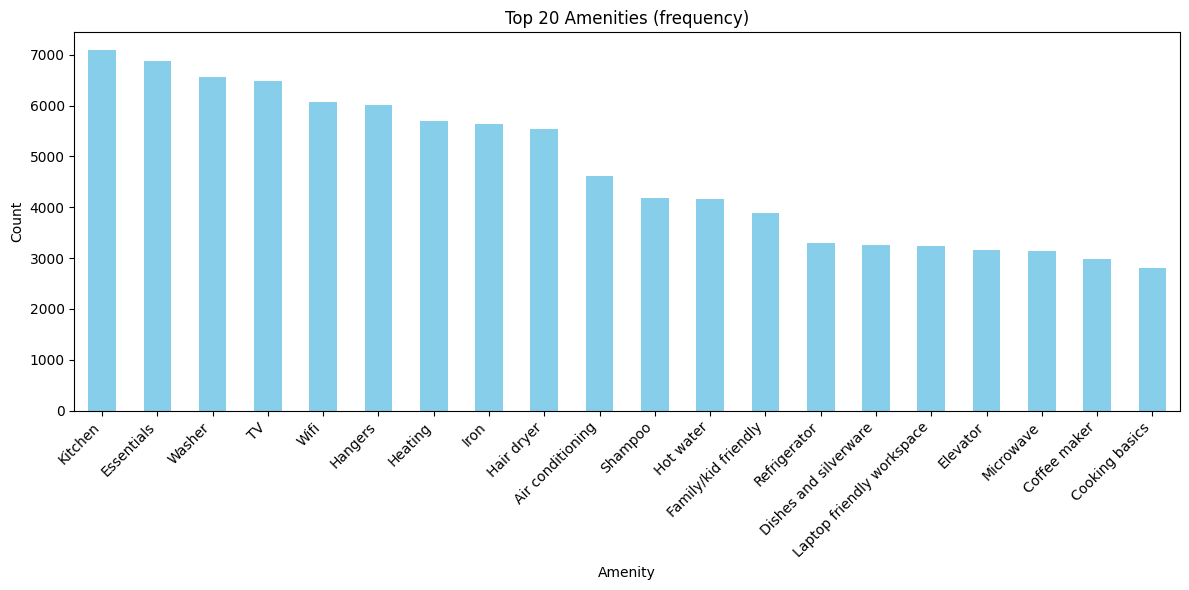

In [50]:
# Top 20 Amenities
import matplotlib.pyplot as plt

# count amenity
amenity_counts = amenities_df['prestacion'].value_counts()

# top 20 amenities
top_20_amenities = amenity_counts.head(20)

#  bar plot
plt.figure(figsize=(12, 6))
top_20_amenities.plot(kind='bar', color='skyblue')
plt.title('Top 20 Amenities (frequency)')
plt.xlabel('Amenity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## and the top 20 but with average price

        apartment_id  id_correlativo        prestacion  average_price
0              11964               1                TV    1115.307242
1              11964               2          Internet    1101.084668
2              11964               3              Wifi    1051.039132
3              11964               4  Air conditioning    1141.999133
4              11964               5          Elevator     865.462729
...              ...             ...               ...            ...
167569      32423292               3      Pets allowed    1108.308231
167570      32423292               4            Washer    1091.353776
167571      32423292               5           Hangers    1019.270764
167572      32423292               6              Iron    1094.549911
167573      32423292               7  Private entrance    1315.546176

[167574 rows x 4 columns]


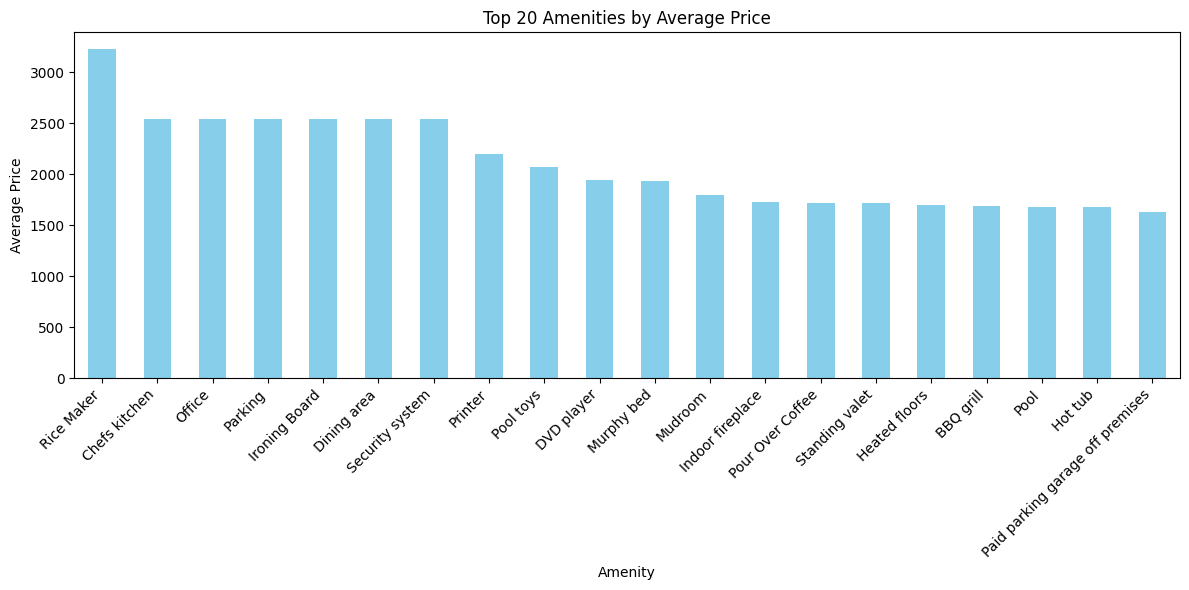

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# merge
merged_df = pd.merge(amenities_df, df[['apartment_id', 'price']], on='apartment_id', how='left')

# Calculate the average price for each amenity
average_price_by_amenity = merged_df.groupby('prestacion')['price'].mean().reset_index()
average_price_by_amenity.rename(columns={'price': 'average_price'}, inplace=True)

# Merge the average price back into the amenities dataframe
amenities_df = pd.merge(amenities_df, average_price_by_amenity, on='prestacion', how='left')

# Display the updated amenities_df
print(amenities_df)

# Now you can create the bar plot using the average price
plt.figure(figsize=(12, 6))
amenities_df.groupby('prestacion')['average_price'].mean().sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Amenities by Average Price')
plt.xlabel('Amenity')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

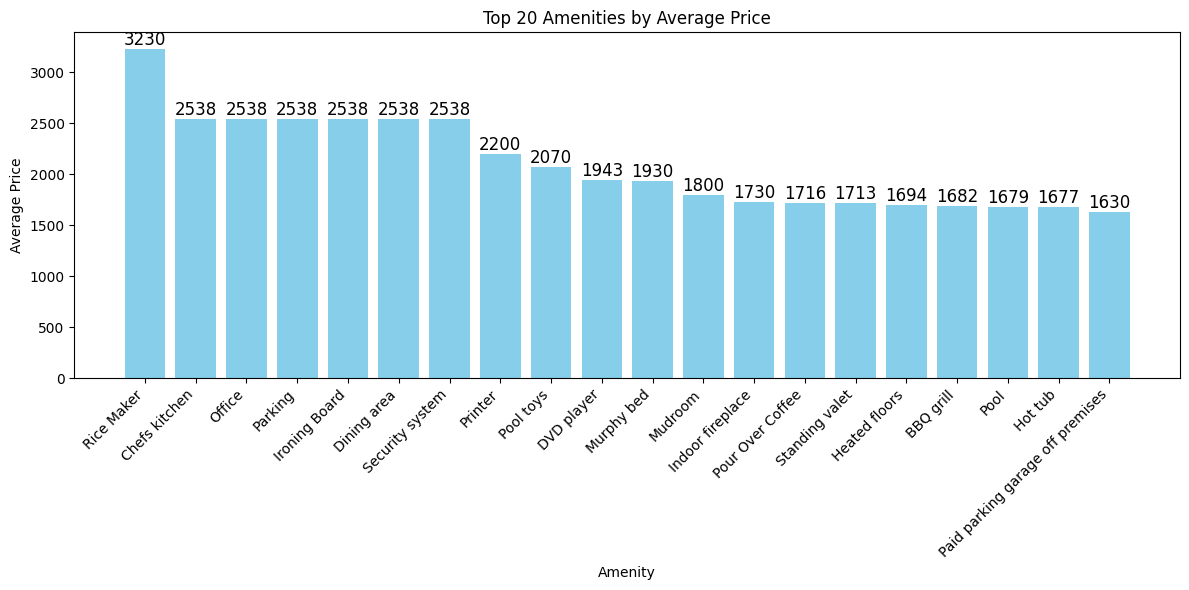

In [52]:
plt.figure(figsize=(12, 6))
average_prices = amenities_df.groupby('prestacion')['average_price'].mean().sort_values(ascending=False).head(20)
bars = plt.bar(average_prices.index, average_prices.values, color='skyblue')
plt.title('Top 20 Amenities by Average Price')
plt.xlabel('Amenity')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Add the average price as a label on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Correlation matrix
### First distribution analysis

We check the distribution type. This is necessary to determine a method in a correlation matrix

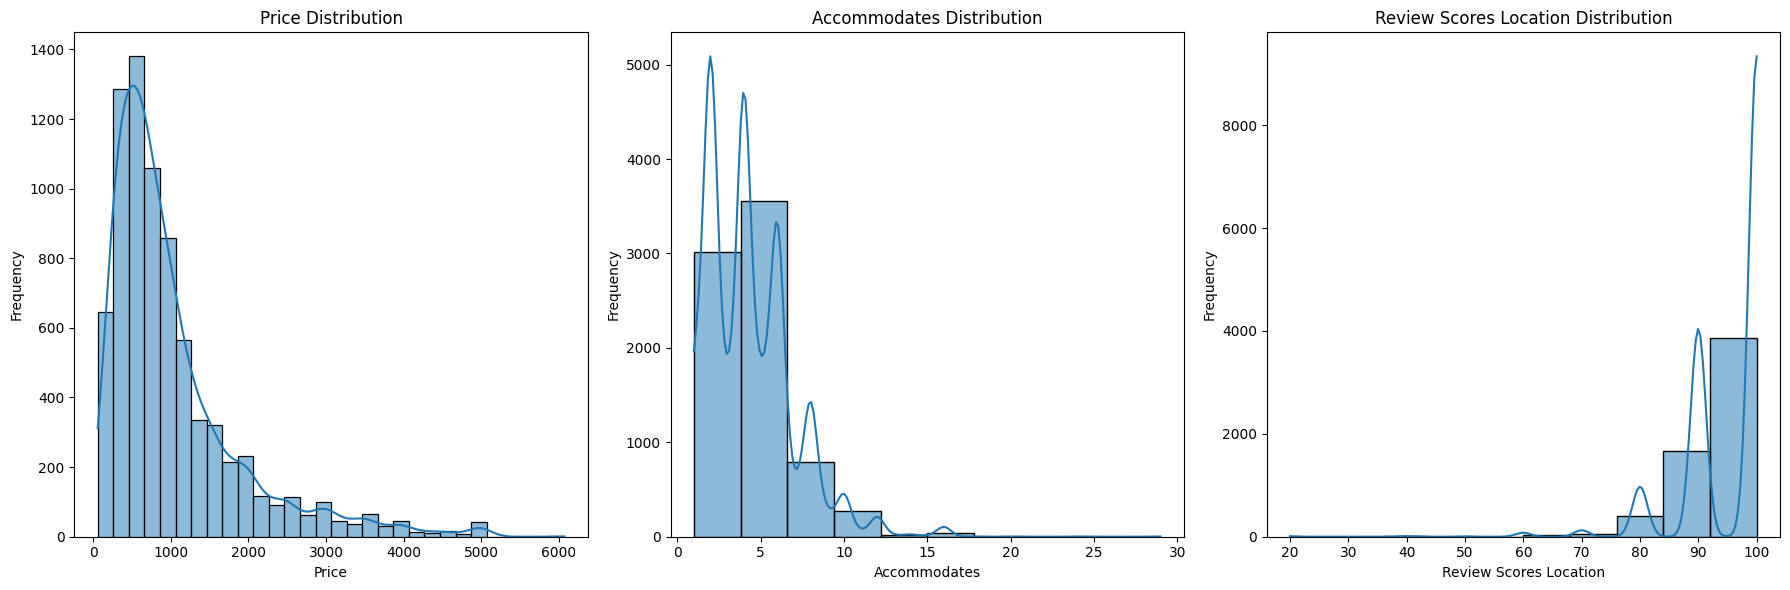

In [53]:
import matplotlib.pyplot as plt

# ## distribution

plt.figure(figsize=(18, 6))  

plt.subplot(1, 3, 1)  # Subplot for 'price'
sns.histplot(df['price'], bins=30, kde=True)  # Adjust number of bins as needed
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)  # Subplot for 'accommodates'
sns.histplot(df['accommodates'], bins=10, kde=True)  # Adjust number of bins as needed
plt.title('Accommodates Distribution')
plt.xlabel('Accommodates')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)  # Subplot for 'review_scores_location'
sns.histplot(df['review_scores_location'], bins=10, kde=True)  # Adjust number of bins as needed
plt.title('Review Scores Location Distribution')
plt.xlabel('Review Scores Location')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Correlation Matrix
First approximation, using the number of services and the intensity of the correlation with price.

The Spearman correlation matrix is ​​shown below, since the distribution, as shown above, is not normal

## Merge, Group by and count amenities

In [54]:
import pandas as pd

# merge 1 -> N
merged_df = pd.merge(df, amenities_df, on='apartment_id', how='inner')

#group by, count amenities
grouped_amenities = merged_df.groupby(['accommodates', 'review_scores_location', 'standardized_city', 'apartment_id', 'price'])['prestacion'].count().reset_index(name='amenity_count')
grouped_amenities

,accommodates,review_scores_location,standardized_city,apartment_id,price,amenity_count
0,1,40.0,Barcelona,14965707,300.0,11
1,1,60.0,Barcelona,20236173,550.0,13
2,1,60.0,Madrid,28379429,110.0,46
3,1,70.0,Barcelona,17521644,380.0,12
4,1,70.0,Barcelona,20950596,80.0,8
...,...,...,...,...,...,...
6029,16,100.0,Málaga,23588436,1880.0,28
6030,16,100.0,Málaga,25368513,150.0,10
6031,16,100.0,Palma,11162926,3860.0,21
6032,16,100.0,Palma,13792358,3048.0,22


## Correlation Matrix

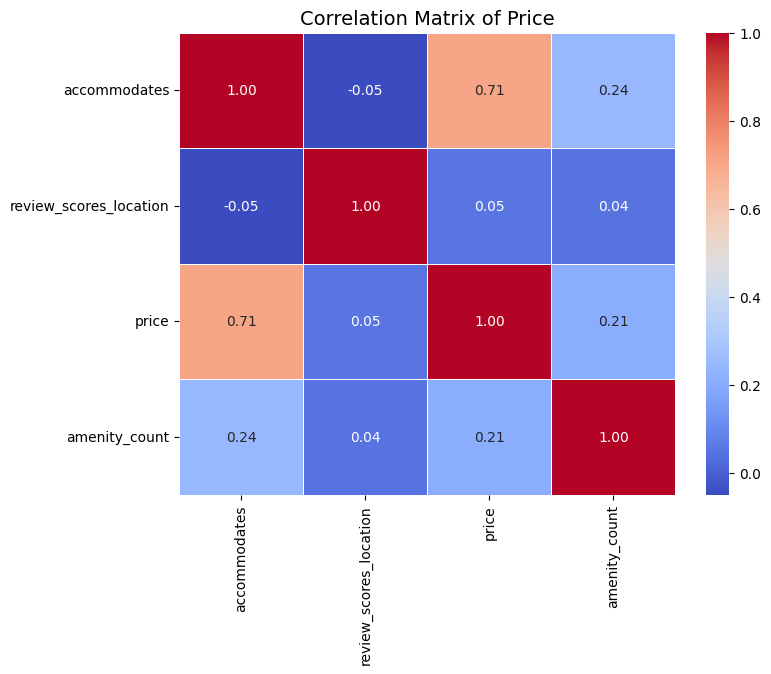

In [55]:
import pandas as pd
import numpy as np

numeric_df = grouped_amenities[['accommodates', 'review_scores_location', 'price', 'amenity_count']]

# Remove rows with missing values in selected columns
numeric_df = numeric_df.dropna()

# Convert 'price' column to numeric, handling errors
numeric_df['price'] = pd.to_numeric(numeric_df['price'], errors='coerce')
numeric_df = numeric_df.dropna(subset=['price'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr(method="spearman")

correlation_matrix

# graficar correlación en var numéricos

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 10}) # Use a more visually appealing colormap and format annotations
plt.title('Correlation Matrix of Price', fontsize=14)
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)
plt.show()

## Correlation Matrix by City

Correlation Matrix for Málaga:
                        accommodates  review_scores_location     price  \
accommodates                1.000000                0.052310  0.578174   
review_scores_location      0.052310                1.000000  0.150241   
price                       0.578174                0.150241  1.000000   
amenity_count               0.175143                0.035168  0.182614   

                        amenity_count  
accommodates                 0.175143  
review_scores_location       0.035168  
price                        0.182614  
amenity_count                1.000000  


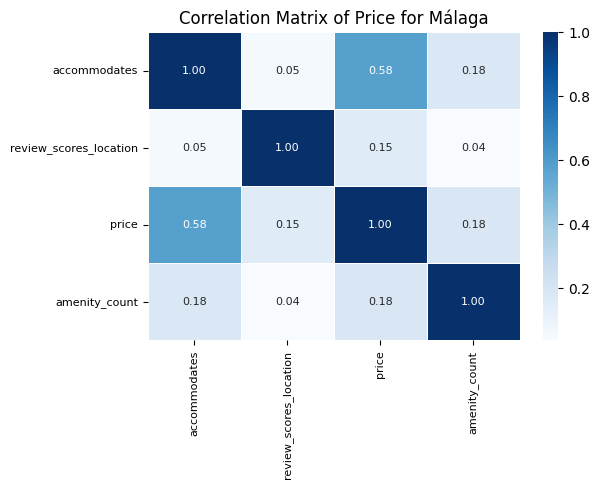

Correlation Matrix for Madrid:
                        accommodates  review_scores_location     price  \
accommodates                1.000000                0.080222  0.696565   
review_scores_location      0.080222                1.000000  0.194460   
price                       0.696565                0.194460  1.000000   
amenity_count               0.215169                0.052348  0.189104   

                        amenity_count  
accommodates                 0.215169  
review_scores_location       0.052348  
price                        0.189104  
amenity_count                1.000000  


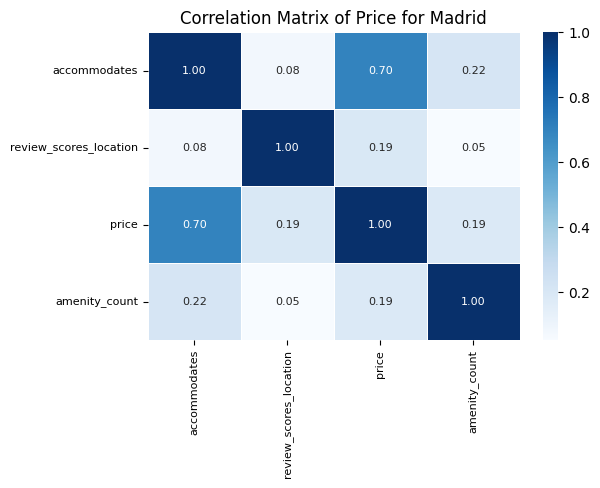

Correlation Matrix for Sevilla:
                        accommodates  review_scores_location     price  \
accommodates                1.000000                0.100056  0.525814   
review_scores_location      0.100056                1.000000  0.195260   
price                       0.525814                0.195260  1.000000   
amenity_count               0.119473                0.012918  0.061115   

                        amenity_count  
accommodates                 0.119473  
review_scores_location       0.012918  
price                        0.061115  
amenity_count                1.000000  


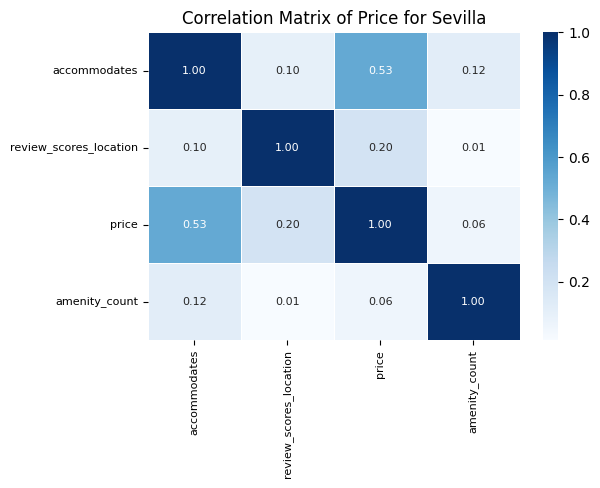

Correlation Matrix for Barcelona:
                        accommodates  review_scores_location     price  \
accommodates                1.000000               -0.082041  0.718255   
review_scores_location     -0.082041                1.000000  0.037722   
price                       0.718255                0.037722  1.000000   
amenity_count               0.288340                0.087866  0.273609   

                        amenity_count  
accommodates                 0.288340  
review_scores_location       0.087866  
price                        0.273609  
amenity_count                1.000000  


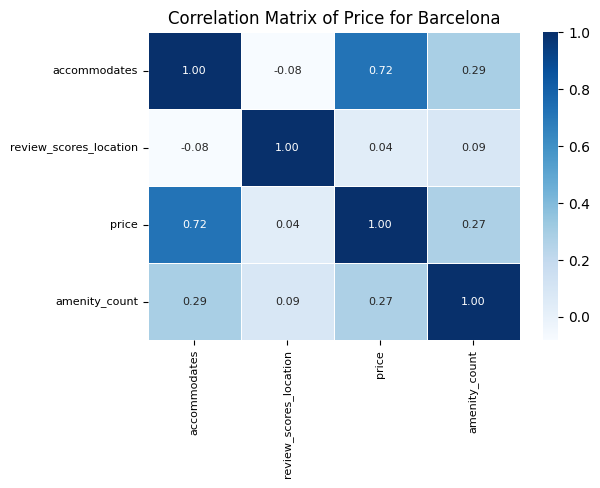

Correlation Matrix for Girona:
                        accommodates  review_scores_location     price  \
accommodates                1.000000               -0.048205  0.599176   
review_scores_location     -0.048205                1.000000  0.060954   
price                       0.599176                0.060954  1.000000   
amenity_count               0.115479                0.094529  0.074477   

                        amenity_count  
accommodates                 0.115479  
review_scores_location       0.094529  
price                        0.074477  
amenity_count                1.000000  


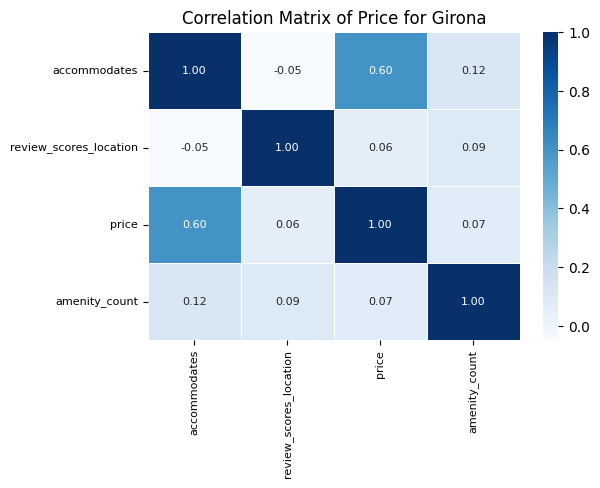

Correlation Matrix for Valencia:
                        accommodates  review_scores_location     price  \
accommodates                1.000000               -0.111227  0.636913   
review_scores_location     -0.111227                1.000000  0.096180   
price                       0.636913                0.096180  1.000000   
amenity_count               0.075970                0.025064  0.069354   

                        amenity_count  
accommodates                 0.075970  
review_scores_location       0.025064  
price                        0.069354  
amenity_count                1.000000  


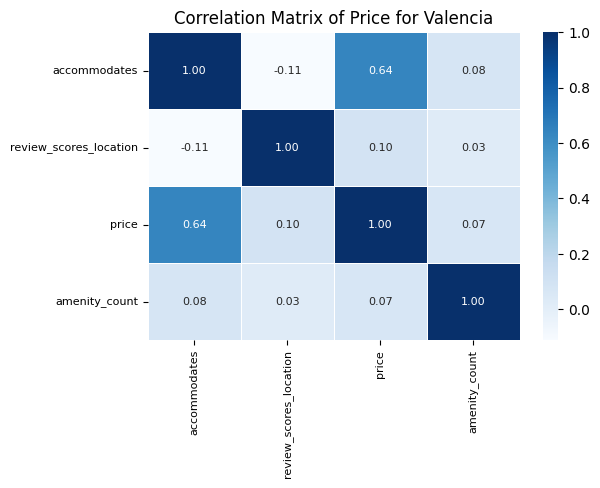

Correlation Matrix for Palma:
                        accommodates  review_scores_location     price  \
accommodates                1.000000               -0.118285  0.666556   
review_scores_location     -0.118285                1.000000 -0.003301   
price                       0.666556               -0.003301  1.000000   
amenity_count               0.157246               -0.037279  0.142449   

                        amenity_count  
accommodates                 0.157246  
review_scores_location      -0.037279  
price                        0.142449  
amenity_count                1.000000  


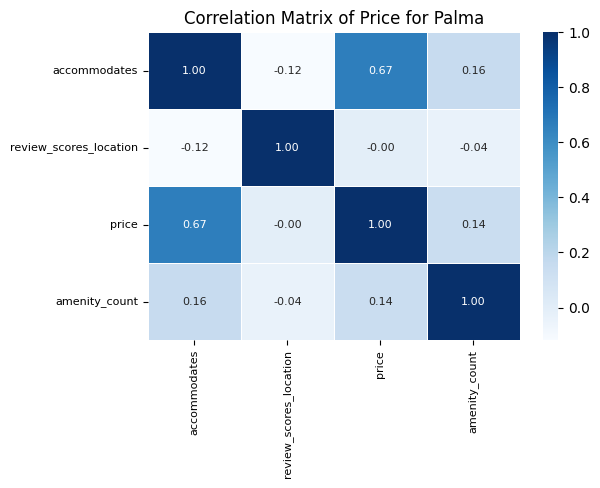

Correlation Matrix for Menorca:
                        accommodates  review_scores_location     price  \
accommodates                1.000000                0.153064  0.727072   
review_scores_location      0.153064                1.000000  0.095047   
price                       0.727072                0.095047  1.000000   
amenity_count               0.102628               -0.112249  0.117769   

                        amenity_count  
accommodates                 0.102628  
review_scores_location      -0.112249  
price                        0.117769  
amenity_count                1.000000  


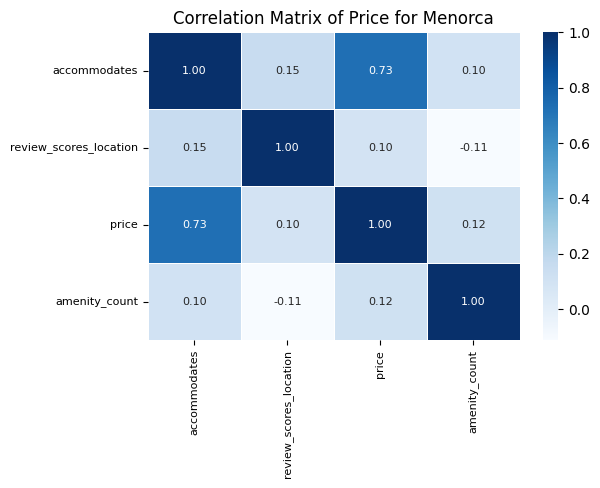

In [56]:
# correlation matrix by city

import pandas as pd
import matplotlib.pyplot as plt
# Assuming 'merged_df' is your DataFrame from the previous code

for city in merged_df['standardized_city'].unique():
    city_df = merged_df[merged_df['standardized_city'] == city]
    grouped_amenities_city = city_df.groupby(['accommodates', 'review_scores_location', 'apartment_id', 'price'])['prestacion'].count().reset_index(name='amenity_count')
    numeric_df_city = grouped_amenities_city[['accommodates', 'review_scores_location', 'price', 'amenity_count']]

    # Remove rows with missing values
    numeric_df_city = numeric_df_city.dropna()

    # Convert 'price' to numeric, handling errors
    numeric_df_city['price'] = pd.to_numeric(numeric_df_city['price'], errors='coerce')
    numeric_df_city = numeric_df_city.dropna(subset=['price'])

    # Calculate the correlation matrix
    correlation_matrix_city = numeric_df_city.corr(method="spearman")
    
    print(f"Correlation Matrix for {city}:")
    print(correlation_matrix_city)

    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix_city, annot=True, cmap='Blues', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title(f'Correlation Matrix of Price for {city}', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [57]:
merged_df_amenities_new = pd.merge(df, amenities_df, on="apartment_id", how="left")

## Multiple Linear Regression

In [58]:
# Obtener las 10 prestaciones más comunes
top_10_prestaciones = (
    merged_df_amenities_new["prestacion"]
    .value_counts()
    .head(10)
    .index
)

# Filtrar el dataframe a solo esas prestaciones
df_top_freq = merged_df_amenities_new[merged_df_amenities_new["prestacion"].isin(top_10_prestaciones)].dropna(
    subset=["accommodates", "review_scores_location", "price"]
)


In [59]:

# Librerías
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf  
from sklearn.linear_model import LinearRegression


# MODEL 
# Elimina nulos por si acaso
df = merged_df_amenities_new.dropna(subset=["prestacion", "accommodates", "review_scores_location", "price"])

# Modelo con variable dummy para 'prestacion'
mlr = smf.ols(
    formula="price ~ accommodates + review_scores_location + C(prestacion)", data=df_top_freq).fit()

# Resultado
print(mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     2924.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:16:27   Log-Likelihood:            -3.8538e+05
No. Observations:               48933   AIC:                         7.708e+05
Df Residuals:                   48921   BIC:                         7.709e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [60]:
 pip install statsmodels 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Conclusion and Recommendations

**General Observations:**  
***Executive Business Analysis***

***Most Expensive Room Types***


***Significant Price Variations by Location***


**Recommendation:** 
